In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from skimage.exposure import match_histograms
from skimage.color import rgb2gray
from skimage.morphology import area_opening, area_closing
from skimage.filters import gaussian
from skimage.metrics import structural_similarity as ssim
from skimage.segmentation import chan_vese

In [48]:
data_path = 'data'


def read_image(img_name):
    
    img = np.array(Image.open(os.path.join(data_path, img_name)))
    
    return img


def norm(img, rng=(0, 255)):
    r_min = img.min()
    r_max = img.max()
    t_min = rng[0]
    t_max = rng[1]

    return (img - r_min) / (r_max - r_min) * (t_max-t_min) + t_min


def get_channel_diff(real, fake, channel=0, threshold='manual', set_thresh=None):
    
    real = gaussian(real, sigma=1, multichannel=True) * 255.0
    fake = gaussian(fake, sigma=1, multichannel=True) * 255.0
    
    # bring real image in the same colour tone with the fake one
    matched = match_histograms(real, fake).astype(int)
    
    # the matched image is the real image now
    real = matched[:, :, channel]
    fake = fake[:, :, channel]
    
    diff = real - fake
    
    abs_diff = np.absolute(diff)

    # median thing is a bad idea, just use thresh = 30
    if threshold == 'median':
        thresh = np.median(abs_diff) * 4.5
    else:
        if set_thresh:
            thresh = set_thresh
        else:
            thresh = 30 # 30
        
    out_diff = (abs_diff >= thresh).astype(int)
    
    return out_diff


def get_diff(real, fake, threshold='manual', set_thresh=None):
    
    ch0 = get_channel_diff(real, fake, channel=0, threshold=threshold, set_thresh=set_thresh)
    ch1 = get_channel_diff(real, fake, channel=1, threshold=threshold, set_thresh=set_thresh)
    ch2 = get_channel_diff(real, fake, channel=2, threshold=threshold, set_thresh=set_thresh)
    
    ch = ch0 + ch1 + ch2
    ch = (ch > 0).astype(int)
    
    ch = area_opening(ch, area_threshold=200)
    ch = area_closing(ch, area_threshold=500)
    
    return ch


def get_seg(real, fake):
    
    _, diff = ssim(real, fake, full=True, multichannel=True)

    diff_norm = norm(diff)
    
    # add up channels
    diff_ch_sum = diff_norm[:,:,0].astype(int) + diff_norm[:,:,1].astype(int) + diff_norm[:,:,2].astype(int)
    
    # normalise to 0-255
    diff_ch_norm = norm(diff_ch_sum)
    
#     plt.imshow(diff_ch_norm, cmap='gray')
    
    seg = chan_vese(diff_ch_norm)
    
    return seg


def get_img_mask(suffix, show=True, threshold='manual', set_thresh=None, segmentation=False):
    
    real = read_image('real_r' + str(suffix) + '.png')
    fake = read_image('fake_s' + str(suffix) + '.png')

    diff = get_diff(real, fake, threshold=threshold, set_thresh=set_thresh)
    
    if segmentation:
        seg = get_seg(real, fake)
    
    if show:
        if segmentation:
            f, axarr = plt.subplots(1, 5, figsize=(15, 5))
            axarr[0].imshow(real)
            axarr[1].imshow(fake)
            axarr[2].imshow(diff, cmap='gray')
            axarr[3].imshow(seg, cmap='gray')
            axarr[4].imshow(np.invert((diff * seg).astype(bool)), cmap='gray')
        else:
            f, axarr = plt.subplots(1, 3, figsize=(15, 5))
            axarr[0].imshow(real)
            axarr[1].imshow(fake)
            axarr[2].imshow(np.invert((diff).astype(bool)), cmap='gray')
    
    if segmentation:
        return np.invert((diff * seg).astype(bool))
    else:
        return np.invert((diff).astype(bool))

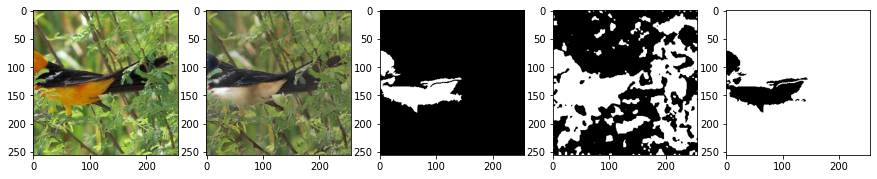

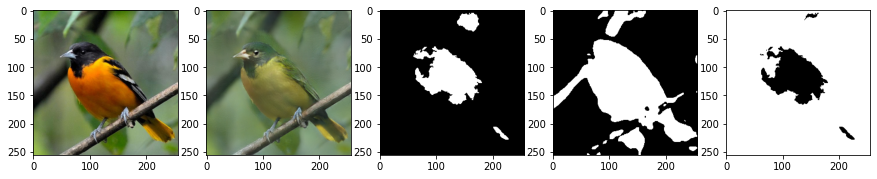

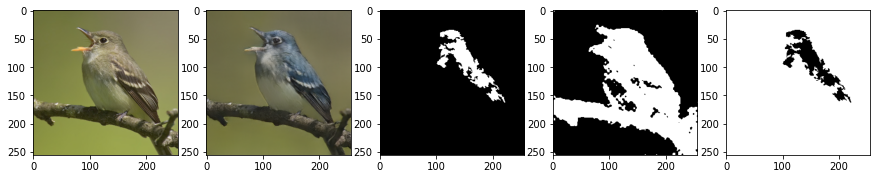

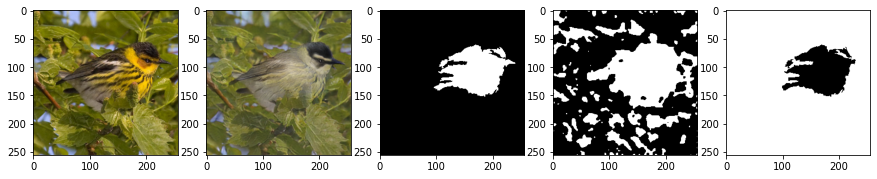

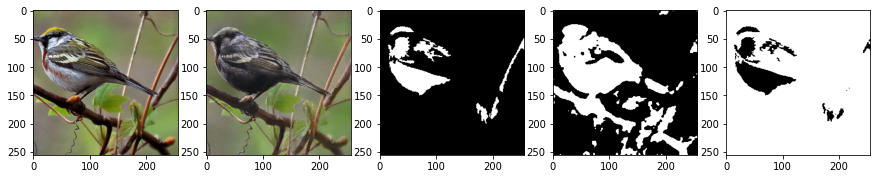

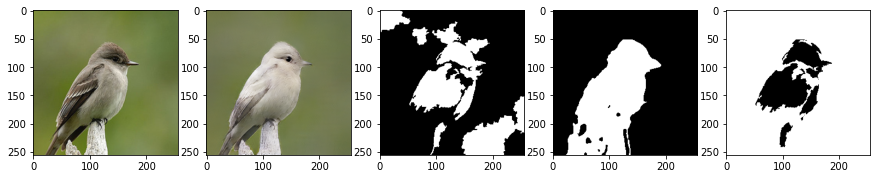

In [49]:
imgs_suffix = [153, 813, 326, 417, 423, 579]
#imgs_suffix = [813]

for img_suffix in imgs_suffix:
    mask = get_img_mask(img_suffix, set_thresh=30, segmentation=True, show=True)
#     plt.imshow(mask, cmap='gray')

In [ ]:
# real = read_image('real_r813.png')
# fake = read_image('fake_s813.png')

# matched = match_histograms(real, fake).astype(int)

# score, diff = ssim(real, fake, full=True, multichannel=True)
# #score, diff = ssim(matched, fake, full=True, multichannel=True)

# # normalize between 0 and 255
# r_min = diff.min()
# r_max = diff.max()
# t_min = 0
# t_max = 255

# diff_norm = (diff - r_min) / (r_max - r_min) * (t_max-t_min) + t_min

# #diff_gray = rgb2gray(diff_norm)

# #diff = (diff < 50).astype(int)

# #diff = area_closing(diff, area_threshold=5000)

# diff_ch_sum = diff_norm[:,:,0].astype(int) + diff_norm[:,:,1].astype(int) + diff_norm[:,:,2].astype(int)

# # normalize between 0 and 255
# r_min = diff_ch_sum.min()
# r_max = diff_ch_sum.max()
# t_min = 0
# t_max = 255

# diff_ch_norm = (diff_ch_sum - r_min) / (r_max - r_min) * (t_max-t_min) + t_min

# #plt.imshow(diff_norm[:,:,2].astype(int), cmap='gray')
# #plt.imshow(diff_norm.astype(int))
# #plt.imshow(diff_gray.astype(int), cmap='gray')

# #plt.imshow(diff_ch_norm.astype(int), cmap='gray')

# seg = chan_vese(diff_ch_norm)

# plt.imshow(seg.astype(int), cmap='gray')